### Predicting Customer Churn

### Environment Setup

In [1]:
#Uncomment and run once to install the package in your runtime environment
!pip install sklearn-pandas

  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.3
    Uninstalling pandas-1.1.3:
      Successfully uninstalled pandas-1.1.3


In [3]:
import pandas as pd
import numpy as np
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


### Step 1: Load data 

In [5]:
import pandas as pd

customer_churn = pd.read_csv('churn.csv')
customer_churn.head()


,ID,CHURN
0,6,F
1,11,F
2,22,F
3,23,F
4,35,T


In [6]:
customer = pd.read_csv('customer-profile.csv')
customer.head()

,ID,Gender,Status,Children,Est Income,Car Owner,Age,AvgMonthlySpend,CustomerSupportCalls,Paymethod,MembershipPlan
0,11,M,S,2.0,96.33,N,56.473333,32.88,1.0,CC,1.0
1,14,F,M,2.0,52004.80,N,25.140000,23.11,0.0,CH,1.0
2,22,M,S,1.0,57626.90,Y,43.906667,38.96,0.0,CC,2.0
3,23,M,M,2.0,20078.00,N,32.846667,6.33,0.0,CC,4.0
4,35,F,S,0.0,78851.30,N,48.373333,28.66,0.0,CC,4.0


In [7]:
customer = pd.read_csv('customer-profile.csv')
customer.head()

,ID,Gender,Status,Children,Est Income,Car Owner,Age,AvgMonthlySpend,CustomerSupportCalls,Paymethod,MembershipPlan
0,11,M,S,2.0,96.33,N,56.473333,32.88,1.0,CC,1.0
1,14,F,M,2.0,52004.80,N,25.140000,23.11,0.0,CH,1.0
2,22,M,S,1.0,57626.90,Y,43.906667,38.96,0.0,CC,2.0
3,23,M,M,2.0,20078.00,N,32.846667,6.33,0.0,CC,4.0
4,35,F,S,0.0,78851.30,N,48.373333,28.66,0.0,CC,4.0


### Step 2: Merge Files

In [8]:
data = pd.merge(customer, customer_churn, on='ID')

### Step 3: Rename some columns
This step is to remove spaces from columns names, it's an example of data preparation that you may want to do before creating a model. 

In [9]:
data.columns

Index(['ID', 'Gender', 'Status', 'Children', 'Est Income', 'Car Owner', 'Age',
       'AvgMonthlySpend', 'CustomerSupportCalls', 'Paymethod',
       'MembershipPlan', 'CHURN'],
      dtype='object')

In [10]:
data.rename(columns={'Est Income':'EstIncome', 'Car Owner':'CarOwner' }, inplace=True)

In [11]:
data.head()

,ID,Gender,Status,Children,EstIncome,CarOwner,Age,AvgMonthlySpend,CustomerSupportCalls,Paymethod,MembershipPlan,CHURN
0,11,M,S,2.0,96.33,N,56.473333,32.88,1.0,CC,1.0,F
1,22,M,S,1.0,57626.90,Y,43.906667,38.96,0.0,CC,2.0,F
2,23,M,M,2.0,20078.00,N,32.846667,6.33,0.0,CC,4.0,F
3,35,F,S,0.0,78851.30,N,48.373333,28.66,0.0,CC,4.0,T
4,36,F,S,1.0,17540.70,Y,62.786667,13.45,0.0,Auto,4.0,T


In [12]:
data.shape

(785, 12)

### Step 4: Data understanding

In [13]:
data.describe()

,ID,Children,EstIncome,Age,AvgMonthlySpend,CustomerSupportCalls,MembershipPlan
count,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000
mean,1962.872611,1.131210,49411.709108,42.062616,59.886841,0.114650,2.508280
std,1090.896925,0.831066,30976.276910,15.226786,57.342251,0.456922,1.157383
min,11.000000,0.000000,96.330000,12.326667,0.790000,0.000000,1.000000
25%,1046.000000,0.000000,19749.300000,27.746667,14.380000,0.000000,1.000000
50%,1982.000000,1.000000,49910.700000,45.360000,39.620000,0.000000,2.000000
75%,2871.000000,2.000000,76161.400000,54.013333,87.880000,0.000000,4.000000
max,3824.000000,2.000000,120000.000000,77.000000,332.460000,4.000000,4.000000


In [14]:
# Uncomment if you would like to see the profile report

#Uncomment and run once to install the package in your runtime environment
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [15]:
# Uncomment if you would like to see the profile report
#from pandas_profiling import ProfileReport
    
#profile = ProfileReport(data, title="Data Profiling Report")
#profile.to_widgets()

### Step 5: Build the sklearn pipeline and the Random Forest model


In [16]:
# Define input data to the model
X = data.drop(['ID','CHURN'], axis=1)

In [17]:
# Define the target variable and encode with value between 0 and n_classes-1, that is from T/F to 1/0
le = LabelEncoder()
y = le.fit_transform(data['CHURN'])

In [18]:
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  F
1:  T


In [19]:
# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

#### Use the DataFrameMapper class to declare transformations and variable imputations.

* LabelBinarizer - Converts a categorical variable into a dummy variable (aka binary variable)
* StandardScaler - Standardize features by removing the mean and scaling to unit variance, z = (x - u) / s

See docs: 
* https://github.com/scikit-learn-contrib/sklearn-pandas
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
* https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [20]:

mapper_good = DataFrameMapper([
    (['Gender'], LabelBinarizer()),
    (['Status'], LabelBinarizer()),
    (['CarOwner'], LabelBinarizer()),
    (['Paymethod'], LabelBinarizer()),
    (['MembershipPlan'], LabelBinarizer()),
    (['Children'],  StandardScaler()),
    (['EstIncome'],  StandardScaler()),
    (['Age'],  StandardScaler()),
    (['AvgMonthlySpend'],  StandardScaler()),
    (['CustomerSupportCalls'],  StandardScaler())], default=False)


In [21]:
# Instantiate the Classifier
random_forest = RandomForestClassifier(random_state=5)

# Define the steps in the pipeline to sequentially apply a list of transforms and the estimator, i.e. RandomForestClassifier
steps = [('mapper', mapper_good),('RandonForestClassifier', random_forest)]
pipeline = sklearn.pipeline.Pipeline(steps)

# train the model
model=pipeline.fit( X_train, y_train )

model

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['Gender'], LabelBinarizer()),
                                           (['Status'], LabelBinarizer()),
                                           (['CarOwner'], LabelBinarizer()),
                                           (['Paymethod'], LabelBinarizer()),
                                           (['MembershipPlan'],
                                            LabelBinarizer()),
                                           (['Children'], StandardScaler()),
                                           (['EstIncome'], StandardScaler()),
                                           (['Age'], StandardScaler()),
                                           (['AvgMonthlySpend'],
                                            StandardScaler()),
                                           (['CustomerSupportCalls'],
                                            StandardScaler())])),
   

In [22]:
# Display Label Mapping to assist with interpretation of the model
label_mapping=le.inverse_transform([0,1])
print('0: ', label_mapping[0])
print('1: ', label_mapping[1])

0:  F
1:  T


In [23]:
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )

### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )

### and print the report
print(report)

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       127
           1       0.74      0.64      0.69       109

    accuracy                           0.73       236
   macro avg       0.74      0.73      0.73       236
weighted avg       0.73      0.73      0.73       236



###  Step 6:  Tune the model to find the best model

In [24]:
# List keys to the model param to tune
#model.get_params().keys()

In [25]:
parameters = { 'RandonForestClassifier__max_depth': [5,8,10],
               'RandonForestClassifier__n_estimators': [150,180,200]}

In [26]:
grid_obj = GridSearchCV(estimator=model, param_grid=parameters,  cv=3)

In [27]:
# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)


In [28]:
# Get the estimator
best_clf = grid_fit.best_estimator_

In [29]:
best_predictions = best_clf.predict(X_test)

In [30]:
best_predictions_report = sklearn.metrics.classification_report( y_test, best_predictions )

In [31]:
print('Results of best fitted model: \n\n',best_predictions_report)

Results of best fitted model: 

               precision    recall  f1-score   support

           0       0.74      0.83      0.78       127
           1       0.77      0.65      0.71       109

    accuracy                           0.75       236
   macro avg       0.75      0.74      0.74       236
weighted avg       0.75      0.75      0.75       236



In [32]:
print('Results of default model: \n\n',report)

Results of default model: 

               precision    recall  f1-score   support

           0       0.73      0.81      0.77       127
           1       0.74      0.64      0.69       109

    accuracy                           0.73       236
   macro avg       0.74      0.73      0.73       236
weighted avg       0.73      0.73      0.73       236



In [33]:
m_step=pipeline.named_steps['mapper']

In [34]:
m_step.transformed_names_

['Gender',
 'Status_D',
 'Status_M',
 'Status_S',
 'CarOwner',
 'Paymethod_Auto',
 'Paymethod_CC',
 'Paymethod_CH',
 'MembershipPlan_1.0',
 'MembershipPlan_2.0',
 'MembershipPlan_3.0',
 'MembershipPlan_4.0',
 'Children',
 'EstIncome',
 'Age',
 'AvgMonthlySpend',
 'CustomerSupportCalls']

In [35]:
features = m_step.transformed_names_

In [36]:
# Get the features importance
importances = pipeline.named_steps['RandonForestClassifier'][1].feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

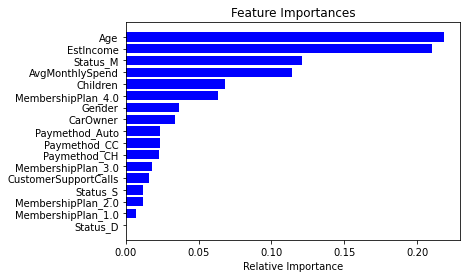

In [37]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

### Step 7: Save the Model file
*In this notebook we demontrate how to save the model to the project (it will be displayed under Data Assets). You can also save the model file to any storage type - Storage Volume (shared file system), Git, Object Storage, etc.*

In [43]:
import pickle
# Save the model to working directory. Pickle is one of the most frequently used options for saving Python models, but you can also use other approaches to save the model file. 

# Modify model name to make it easier to distinguish between the model saved with WML and regular save file.
model_name = 'model_trained_externally'
pickle.dump(model, open(model_name, 'wb'))

**After running this cell, you should see the model in your JupyterLab working directory. Upload this model file to Watson Studio. 

**Author:**  Elena Lowery<br/>
**Date:**  April 2022